In [1]:
import pandas as pd
import numpy as np
from fastai.structured import *
from fastai.column_data import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from metrics import print_metrics_binary
#from tqdm import TqdmSynchronisationWarning
np.set_printoptions(threshold=50, edgeitems=20)
from IPython.display import display

In [2]:
#print(torch.cuda.current_device())
torch.cuda.set_device(1)

In [3]:
#warnings.filterwarnings("ignore", category=TqdmSynchronisationWarning)

In [4]:
train = pd.read_csv('./datasets/ihm/train_height.csv')
test = pd.read_csv('./datasets/ihm/test_height.csv')
val = pd.read_csv('./datasets/ihm/val_heigth.csv')
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)
val = val.drop('Unnamed: 0', axis=1)

In [5]:
print(len(train[train['Mortality'] == 1]))
print(len(train[train['Mortality'] == 0]))

180592
1014121


In [6]:
def balance_dataset(df):
    split_set = []
    num_survived = 0
    num_died = 0
    for episode, df_episode in df.groupby('Episode'):
        split_set.append(df_episode)
        if df_episode.iloc[0]['Mortality'] < 1:
            num_survived = num_survived +1
        else:
            num_died = num_died +1
    counter = 0
    for patient in split_set:
        if patient.iloc[0]['Mortality'] == 1 and num_died*4 > counter:
            new_patient = patient.copy()
            new_patient["Episode"] = ("e" + str(counter))
            split_set.append(patient)
            counter = counter +1

    print(num_died+counter, num_survived)
    complete_data =  pd.DataFrame(columns=df.columns)
    complete_data = pd.concat(split_set)
    return complete_data




train_balanced = train

In [7]:
print(len(train_balanced[train_balanced['Mortality'] == 1]))
print(len(train_balanced[train_balanced['Mortality'] == 0]))


print(len(val[val['Mortality'] == 1]))
print(len(val[val['Mortality'] == 0]))


180592
1014121
38996
224337


In [8]:
train_balanced =  balance_dataset(train)
train_size = len(train_balanced)
train_balanced = train_balanced.append(val)


print(train_size)
print(len(train_balanced))
val_idx = list(range(train_size, len(train_balanced)))

9935 12694
1917081
2180414


## Make categorical variables and embedding

In [9]:
cat_vars = ['Capillary refill rate', 'Glascow coma scale eye opening' ,'Glascow coma scale motor response','Glascow coma scale total', 'Glascow coma scale verbal response','Episode', 'Length' ]


for v in cat_vars: train_balanced[v] = train_balanced[v].astype('category').cat.as_ordered()
for v in cat_vars: test[v] = test[v].astype('category').cat.as_ordered()

cat_sz = [(c, len(train_balanced[c].cat.categories)+1) for c in cat_vars]

print(cat_sz)

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

[('Capillary refill rate', 3), ('Glascow coma scale eye opening', 6), ('Glascow coma scale motor response', 7), ('Glascow coma scale total', 14), ('Glascow coma scale verbal response', 6), ('Episode', 17904), ('Length', 221)]


In [10]:
print(len(train_balanced[train_balanced['Mortality'] == 1]))
print(len(train_balanced[train_balanced['Mortality'] == 0]))

941956
1238458


In [14]:
df, y, nas, mapper = proc_df(train_balanced, 'Mortality', do_scale=True)
df_test, y_test, nas_test, mapper_test = proc_df(test, do_scale=True, mapper=mapper, na_dict=nas) 

md = ColumnarModelData.from_data_frame('./datasets/ihm/', val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

In [16]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.9, 1, [ 3000, 1500,750,300], [0.6,0.6,0.6,0.6], y_range=[0,1], crit = torch.nn.functional.binary_cross_entropy)

## Find and set learning rate

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 46%|████▌     | 6837/14978 [00:55<01:05, 124.01it/s, loss=0.211] 

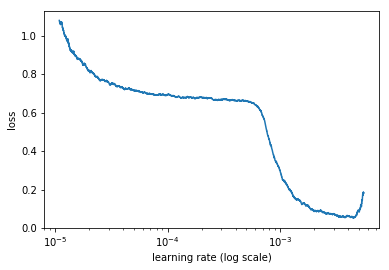

In [17]:
m.lr_find()
m.sched.plot(100)


In [18]:
lr = 0.0001


In [19]:
lrs = [lr/18, lr/9, lr/6]

## Train network

In [20]:
m.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  4%|▎         | 539/14978 [00:04<01:59, 120.90it/s, loss=1.1] 

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/andreas/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/andreas/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/andreas/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                    
    0      0.688505   0.672246  
    1      0.665538   0.636648                                    
    2      0.658122   0.626507                                    



[array([0.62651])]

## Make predictions on test set

In [21]:
def split_test_set(df):
    split_set = []
    for episode, df_episode in df.groupby('Episode'):
        split_set.append(df_episode)
    return split_set

test_split = split_test_set(df_test)

In [22]:

m.Precompute = False
y_true = []
counter = 1
y_predicted = []
for patient in test_split:
    if counter % 500 == 0:
        print(str(counter) + '/' + str(len(test_split)))
    counter=counter+1
    y = patient['Mortality'].iloc[0]
    y_true.append(y)
    p = ColumnarDataset.from_data_frame(patient.drop('Mortality', axis=1),cat_flds=cat_vars)
    y_predicted.append(m.predict_dl(DataLoader(p)).max())
    

500/3236
1000/3236
1500/3236
2000/3236
2500/3236
3000/3236


In [23]:
preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)

## Present results

In [24]:
print_metrics_binary(y_true, preds)


confusion matrix:
[[1379 1483]
 [  74  300]]
accuracy = 0.51885045
precision class 0 = 0.9490709
precision class 1 = 0.16825575
recall class 0 = 0.4818309
recall calss 1 = 0.80213904
AUC of ROC = 0.64198496246221
AUC of PRC = 0.4966312620596605
min(+P, Se) = 0.16825574873808188


{'acc': 0.51885045,
 'auprc': 0.4966312620596605,
 'auroc': 0.64198496246221,
 'minpse': 0.16825574873808188,
 'prec0': 0.9490709,
 'prec1': 0.16825575,
 'rec0': 0.4818309,
 'rec1': 0.80213904}

In [25]:
m.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                                     
    0      0.073836   0.540672  
    1      0.02395    0.60556                                      



[array([0.60556])]

In [26]:
y_true = []
counter = 1
y_predicted = []
for patient in test_split:
    if counter % 500 == 0:
        print(str(counter) + '/' + str(len(test_split)))
    counter=counter+1
    y = patient['Mortality'].iloc[0]
    y_true.append(y)
    p = ColumnarDataset.from_data_frame(patient.drop('Mortality', axis=1),cat_flds=cat_vars)
    y_predicted.append(m.predict_dl(DataLoader(p)).max())

preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)
        
print_metrics_binary(y_true, preds)

500/3236
1000/3236
1500/3236
2000/3236
2500/3236
3000/3236
confusion matrix:
[[2469  393]
 [ 313   61]]
accuracy = 0.7818294
precision class 0 = 0.887491
precision class 1 = 0.13436124
recall class 0 = 0.8626834
recall calss 1 = 0.1631016
AUC of ROC = 0.5128925212166056
AUC of PRC = 0.19709359440446547
min(+P, Se) = 0.1343612334801762


{'acc': 0.7818294,
 'auprc': 0.19709359440446547,
 'auroc': 0.5128925212166056,
 'minpse': 0.1343612334801762,
 'prec0': 0.887491,
 'prec1': 0.13436124,
 'rec0': 0.8626834,
 'rec1': 0.1631016}

In [27]:
m.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                                     
    0      0.012831   0.610768  
    1      0.010353   0.68061                                       



[array([0.68061])]

In [28]:
y_true = []
counter = 1
y_predicted = []
for patient in test_split:
    if counter % 500 == 0:
        print(str(counter) + '/' + str(len(test_split)))
    counter=counter+1
    y = patient['Mortality'].iloc[0]
    y_true.append(y)
    p = ColumnarDataset.from_data_frame(patient.drop('Mortality', axis=1),cat_flds=cat_vars)
    y_predicted.append(m.predict_dl(DataLoader(p)).max())

preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)
        
print_metrics_binary(y_true, preds)

500/3236
1000/3236
1500/3236
2000/3236
2500/3236
3000/3236
confusion matrix:
[[2428  434]
 [ 312   62]]
accuracy = 0.7694685
precision class 0 = 0.8861314
precision class 1 = 0.125
recall class 0 = 0.8483578
recall calss 1 = 0.1657754
AUC of ROC = 0.5070665964117684
AUC of PRC = 0.1935953643172068
min(+P, Se) = 0.125


{'acc': 0.7694685,
 'auprc': 0.1935953643172068,
 'auroc': 0.5070665964117684,
 'minpse': 0.125,
 'prec0': 0.8861314,
 'prec1': 0.125,
 'rec0': 0.8483578,
 'rec1': 0.1657754}

In [29]:
m.fit(lrs, 2, cycle_len=1, cycle_mult=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

 17%|█▋        | 2578/14978 [00:21<01:42, 120.53it/s, loss=0.012]  

KeyboardInterrupt: 

 17%|█▋        | 2578/14978 [00:40<03:12, 64.45it/s, loss=0.012] 

In [ ]:
y_true = []
counter = 1
y_predicted = []
for patient in test_split:
    if counter % 500 == 0:
        print(str(counter) + '/' + str(len(test_split)))
    counter=counter+1
    y = patient['Mortality'].iloc[0]
    y_true.append(y)
    p = ColumnarDataset.from_data_frame(patient.drop('Mortality', axis=1),cat_flds=cat_vars)
    y_predicted.append(m.predict_dl(DataLoader(p)).max())

preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)
        
print_metrics_binary(y_true, preds)